In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.ndimage import uniform_filter1d

from tqdm.auto import tqdm
from joblib import Parallel, delayed


In [2]:

###############################################################################
# PART 1. DATA EXTRACTION & BINNING
###############################################################################
def extract_spike_times(file_path, regions):
    """
    Extract spike times from an HDF5 file.
   
    Parameters:
      file_path: path to the HDF5 file.
      regions: list of region strings to include (e.g., ['uAHL', 'uAHR', ...]).
   
    Returns:
      spike_times_dict: dictionary with keys 4, 6, and 8. Each key maps to a list of trials.
                        Each trial is a list (over neurons) of spike time arrays.
      neuron_ids: (not used further here, but returned for completeness).
    """
    spike_times_dict = {4: np.ones(shape=(1000,10)), 6: np.ones(shape=(1000,10)), 8: np.ones(shape=(1000,10))}
    neuron_ids = []
    return spike_times_dict, neuron_ids

def compute_binned_firing_rates(spike_times_dict, time_window, bin_size=0.001):
    """
    Convert spike times (in seconds) to firing rates in 1-ms bins.
   
    Parameters:
      spike_times_dict: dict with keys 4,6,8; each value is a list of trials.
                        Each trial is a list (over neurons) of spike time arrays.
      time_window: tuple (start, end) in seconds (e.g., (-6, 2)).
      bin_size: bin size in seconds (0.001 sec for 1-ms bins).
   
    Returns:
      firing_rates: dict with the same keys. Each value is a NumPy array of shape
                    (n_trials, n_neurons, n_bins).
      t_bins: array of bin edges.
    """
    t_bins = np.arange(time_window[0], time_window[1] + bin_size, bin_size)
    firing_rates = {}
    for key, trial_list in spike_times_dict.items():
        rates = []
        for trial in trial_list:
            trial_rates = []
            for neuron_spikes in trial:
                counts, _ = np.histogram(neuron_spikes, bins=t_bins)
                # Firing rate in spikes per second
                rate = counts / bin_size  
                trial_rates.append(rate)
            trial_rates = np.array(trial_rates)  # shape: (n_neurons, n_bins)
            rates.append(trial_rates)
        firing_rates[key] = np.array(rates)  # shape: (n_trials, n_neurons, n_bins)
    return firing_rates, t_bins

###############################################################################
# PART 2. POOLING ACROSS SESSIONS TO CREATE A PSEUDOPOPULATION
###############################################################################
def pool_neurons(file_paths, regions, time_window, bin_size=0.001,
                 n_trials_set4=15, n_trials_set6=7, n_trials_set8=8):
    """
    Pool neurons across sessions.
   
    For each session, for each neuron:
      - For set size 4 (low workload): select the first n_trials_set4 trials.
      - For set sizes 6 and 8 (high workload): select the first n_trials_set6 and n_trials_set8 trials.
      - Concatenate these trials to yield 30 trials per neuron.
   
    Returns:
      pooled_neurons: NumPy array of shape (n_trials, total_neurons, n_bins).
      pooled_labels: NumPy array of shape (n_trials, total_neurons) where 0 = low workload (set size 4)
                     and 1 = high workload (set sizes 6+8).
      t_bins: array of time bin edges.
    """
    pooled_neurons_list = []
    pooled_labels_list = []
    for file_path in file_paths:
        # Extract spike times from one session
        spike_times_dict, _ = extract_spike_times(file_path, regions)
        # Compute firing rates in 1-ms bins over the desired time window
        firing_rates, t_bins = compute_binned_firing_rates(spike_times_dict, time_window, bin_size)
        # Check that this session has enough trials in each condition
        if (firing_rates[4].shape[0] < n_trials_set4 or
            firing_rates[6].shape[0] < n_trials_set6 or
            firing_rates[8].shape[0] < n_trials_set8):
            continue  # skip session if insufficient trials
       
        # Extract a fixed number of trials from each condition
        trials_4 = firing_rates[4][:n_trials_set4]  # low workload
        trials_6 = firing_rates[6][:n_trials_set6]
        trials_8 = firing_rates[8][:n_trials_set8]
       
        # For each neuron (assume same neuron count across conditions)
        n_neurons = trials_4.shape[1]
        for neuron in range(n_neurons):
            low_trials = trials_4[:, neuron, :]  # shape: (n_trials_set4, n_bins)
            high_trials_6 = trials_6[:, neuron, :]
            high_trials_8 = trials_8[:, neuron, :]
            high_trials = np.concatenate((high_trials_6, high_trials_8), axis=0)  # shape: (n_trials_set6+n_trials_set8, n_bins)
            neuron_trials = np.concatenate((low_trials, high_trials), axis=0)  # total 30 trials
            pooled_neurons_list.append(neuron_trials)
            # Labels: 0 for low workload (set size 4), 1 for high workload (set sizes 6+8)
            neuron_labels = np.concatenate((np.zeros(n_trials_set4), np.ones(n_trials_set6 + n_trials_set8)))
            pooled_labels_list.append(neuron_labels)
   
    if len(pooled_neurons_list) == 0:
        raise ValueError("No sessions with sufficient trials found.")
   
    pooled_neurons = np.array(pooled_neurons_list)
    pooled_labels = np.array(pooled_labels_list)
    pooled_neurons = np.transpose(pooled_neurons, (1, 0, 2))
    pooled_labels = np.transpose(pooled_labels, (1, 0))
   
    return pooled_neurons, pooled_labels, t_bins


In [3]:

###############################################################################
# PART 3. DECODING PIPELINE (SMOOTHING, SLIDING WINDOWS, RESAMPLING, NULL DISTRIBUTION)
###############################################################################
def smooth_firing_rates_matrix(X, window_size):
    return uniform_filter1d(X.astype(float), size=window_size, axis=2, mode='nearest')


class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def smooth_and_decode(X, labels, t_bins, window_size_ms=1500, step_size_ms=250,
                      n_resamples=500, n_shuffles=500):
    # Smooth the data with a 1500-ms window
    X_smooth = smooth_firing_rates_matrix(X, window_size_ms)
    total_time = X_smooth.shape[2]
   
    # Create sliding windows (indices are in ms since 1-ms bins)
    windows = []
    start = 0
    while start + window_size_ms <= total_time:
        windows.append((start, start + window_size_ms))
        start += step_size_ms

    # Determine number of windows and allocate inner-loop cores
    n_windows = len(windows)
    n_jobs_inner = max(1, 150 // n_windows)  # allocate available cores for inner loops
    
    def process_window(start, end):
        X_window = X_smooth[:, :, start:end]  # shape: (n_trials, n_neurons, window_size_ms)
        n_trials, n_neurons, w = X_window.shape
        # Flatten neurons and time bins for each trial → (n_trials, n_neurons * w)
        X_flat = X_window.reshape(n_trials, n_neurons * w)
        # We assume the labels for each trial are the same across neurons; take the first neuron's labels.
        y = labels[:, 0]
       
        def resample_iteration(seed):
            X_train, X_test, y_train, y_test = train_test_split(
                X_flat, y, test_size=0.3, stratify=y, random_state=seed
            )
            clf = SVC(kernel='linear')
            clf.fit(X_train, y_train)
            acc = clf.score(X_test, y_test) * 100
            return acc

        # Compute resampling accuracies in parallel
        resample_acc = ProgressParallel(n_jobs=n_jobs_inner)(
            delayed(resample_iteration)(seed) for seed in range(n_resamples)
        )
        mean_acc = np.mean(resample_acc)
       
        def null_iteration(seed):
            y_shuf = np.random.permutation(y)
            X_train, X_test, y_train, y_test = train_test_split(
                X_flat, y_shuf, test_size=0.3, stratify=y_shuf, random_state=seed
            )
            clf = SVC(kernel='linear')
            clf.fit(X_train, y_train)
            acc = clf.score(X_test, y_test) * 100
            return acc

        # Compute null distribution accuracies in parallel
        null_acc = ProgressParallel(n_jobs=n_jobs_inner)(
            delayed(null_iteration)(seed) for seed in range(n_shuffles)
        )
        null_acc = np.array(null_acc)
        p_val = np.mean(null_acc >= mean_acc)
        
        print(f"Decoded window: {start} - {end} ms")
        
        return {
            'window': (start, end),
            'mean_acc': mean_acc,
            'acc_dist': resample_acc,
            'null_dist': null_acc,
            'p_val': p_val
        }
    
    # Parallelize processing of each window across 150 cores
    results = Parallel(n_jobs=150)(
        delayed(process_window)(start, end) for start, end in windows
    )
    return results


In [4]:
###############################################################################
# PART 4. MAIN SCRIPT
###############################################################################
# Define folder and file pattern for your data files
# folder_path = '/data/human_mtl_units_scalp_eeg_and_ieeg_verbal_wm/data_nix/'
# file_pattern = "Data_Subject_*_Session_*.h5"
# file_paths = sorted(glob.glob(os.path.join(folder_path, file_pattern)))
# print("Found session files:")
# for fp in file_paths:
#     print(fp)

# Define regions of interest (e.g., all regions)
regions = ['uAHL', 'uAHR', 'uPHL', 'uPHR', 'uECL', 'uECR']
# Define the time window for firing rate computation in seconds (e.g., -6 to 2 sec)
time_window = (-6, 2)
# Use 1-ms binning (0.001 sec)
bin_size = 0.001

# Pool neurons across sessions into a pseudopopulation.
pooled_neurons, pooled_labels, t_bins = pool_neurons("file_paths", regions, time_window, bin_size,
                                                        n_trials_set4=15, n_trials_set6=7, n_trials_set8=8)
print("Pooled neurons shape:", pooled_neurons.shape)  # (n_trials, total_neurons, n_bins)
print("Pooled labels shape:", pooled_labels.shape)      # (n_trials, total_neurons)


   

Pooled neurons shape: (30, 100, 8000)
Pooled labels shape: (30, 100)


In [5]:
# Run the decoding pipeline.
# (We use a 1500-ms decoding window stepped every 250 ms.)
results = smooth_and_decode(pooled_neurons, pooled_labels, t_bins,
                            window_size_ms=1500, step_size_ms=250,
                            n_resamples=500, n_shuffles=500)

 97%|█████████▋| 303/312 [01:14<00:02,  4.04it/s]

Decoded window: 1000 - 2500 ms


 98%|█████████▊| 365/374 [01:27<00:02,  4.15it/s]

Decoded window: 3250 - 4750 ms


 97%|█████████▋| 312/321 [01:46<00:03,  2.94it/s]

Decoded window: 5750 - 7250 ms


 98%|█████████▊| 374/383 [01:56<00:02,  3.20it/s]

Decoded window: 5500 - 7000 ms


 98%|█████████▊| 447/456 [01:57<00:02,  3.79it/s]

Decoded window: 5000 - 6500 ms


 98%|█████████▊| 484/493 [02:03<00:02,  3.91it/s]

Decoded window: 1250 - 2750 ms


100%|██████████| 500/500 [02:08<00:00,  3.90it/s]


Decoded window: 2750 - 4250 ms
Decoded window: 5250 - 6750 ms


 98%|█████████▊| 488/497 [02:09<00:02,  3.75it/s]

Decoded window: 4500 - 6000 ms


 98%|█████████▊| 457/466 [02:06<00:02,  3.62it/s]

Decoded window: 3750 - 5250 ms


 98%|█████████▊| 441/450 [02:11<00:02,  3.36it/s]

Decoded window: 4250 - 5750 ms


 98%|█████████▊| 483/492 [02:08<00:02,  3.77it/s]

Decoded window: 2000 - 3500 ms
Decoded window: 0 - 1500 ms


 98%|█████████▊| 468/477 [02:10<00:02,  3.58it/s]

Decoded window: 2250 - 3750 ms


 98%|█████████▊| 448/457 [02:10<00:02,  3.45it/s]

Decoded window: 1750 - 3250 ms


 98%|█████████▊| 451/460 [02:10<00:02,  3.46it/s]

Decoded window: 2500 - 4000 ms


 98%|█████████▊| 448/457 [02:13<00:02,  3.36it/s]

Decoded window: 1500 - 3000 ms


 98%|█████████▊| 456/465 [02:14<00:02,  3.39it/s]

Decoded window: 3500 - 5000 ms
Decoded window: 3000 - 4500 ms


 98%|█████████▊| 464/473 [02:14<00:02,  3.44it/s]

Decoded window: 4000 - 5500 ms


 98%|█████████▊| 477/486 [02:15<00:02,  3.52it/s]

Decoded window: 250 - 1750 ms


 98%|█████████▊| 488/497 [02:16<00:02,  3.58it/s]

Decoded window: 6250 - 7750 ms
Decoded window: 6500 - 8000 ms
Decoded window: 500 - 2000 ms


 98%|█████████▊| 481/490 [02:13<00:02,  3.60it/s]

Decoded window: 750 - 2250 ms
Decoded window: 6000 - 7500 ms


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Decoded window: 4750 - 6250 ms


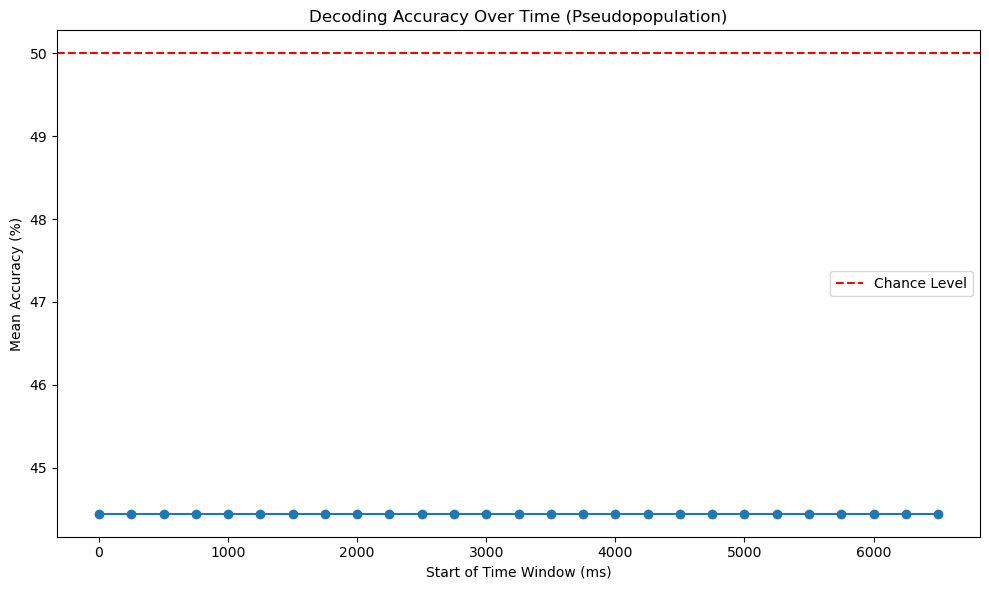

Window (0, 1500): Mean Accuracy = 44.44%, p-value = 1.0000
Window (250, 1750): Mean Accuracy = 44.44%, p-value = 1.0000
Window (500, 2000): Mean Accuracy = 44.44%, p-value = 1.0000
Window (750, 2250): Mean Accuracy = 44.44%, p-value = 1.0000
Window (1000, 2500): Mean Accuracy = 44.44%, p-value = 1.0000
Window (1250, 2750): Mean Accuracy = 44.44%, p-value = 1.0000
Window (1500, 3000): Mean Accuracy = 44.44%, p-value = 1.0000
Window (1750, 3250): Mean Accuracy = 44.44%, p-value = 1.0000
Window (2000, 3500): Mean Accuracy = 44.44%, p-value = 1.0000
Window (2250, 3750): Mean Accuracy = 44.44%, p-value = 1.0000
Window (2500, 4000): Mean Accuracy = 44.44%, p-value = 1.0000
Window (2750, 4250): Mean Accuracy = 44.44%, p-value = 1.0000
Window (3000, 4500): Mean Accuracy = 44.44%, p-value = 1.0000
Window (3250, 4750): Mean Accuracy = 44.44%, p-value = 1.0000
Window (3500, 5000): Mean Accuracy = 44.44%, p-value = 1.0000
Window (3750, 5250): Mean Accuracy = 44.44%, p-value = 1.0000
Window (4000, 

In [6]:
# Plot the mean decoding accuracy over time (using the window start times)
window_starts = [r['window'][0] for r in results]
mean_accuracies = [r['mean_acc'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(window_starts, mean_accuracies, marker='o', linestyle='-')
plt.xlabel('Start of Time Window (ms)')
plt.ylabel('Mean Accuracy (%)')
plt.title('Decoding Accuracy Over Time (Pseudopopulation)')
plt.axhline(50, color='red', linestyle='--', label='Chance Level')
plt.legend()
plt.tight_layout()
plt.show()

# Print p-values for each time window.
for r in results:
    print(f"Window {r['window']}: Mean Accuracy = {r['mean_acc']:.2f}%, p-value = {r['p_val']:.4f}")